In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math
import time
import datetime
import gc
import os
import sys
import pickle

#from pysr import pysr

from simulator import read_orbits, base_classes
from data.solar_system_names import *
from ml_model import *

sys.modules['base_classes'] = base_classes
print('Started')

tf.config.list_physical_devices('CPU')
tf.config.run_functions_eagerly(False)


2024-05-24 18:24:36.169431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 18:24:36.189596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 18:24:36.504896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Started


2024-05-24 18:24:37.161337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 18:24:37.178384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 18:24:37.178496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Global Constants

In [2]:
start_time = time.time()

# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 30 mins
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MSUN*DAY**2

Training variables

In [6]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.01
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
#total_time_traj = 40 #Years <--- that's 1960 to 2000 , I have HALF that data lol
#num_time_steps_total = int(total_time_traj/delta_time)

#so for the value used for training here (520,000) it surpases the number of timesteps of data we currently have (320,000)
#for reference , we have 17,520 30 minute intervals in a year and we venus and mercury takes 255 and 88 days to rotate the sun.
#let's just do a vague 70/30 split for now based on the amount of data we have 224000
#An orbit for saturn is 129110 steps

#num_time_steps_tr = 520000 
num_time_steps_tr = 224000 
#num_time_steps_sr = 500 #??? wtf is this even used?
#num_batches = 13000
batch_size_tr = 32#num_time_steps_tr//num_batches <--- this is overriden
num_batches = num_time_steps_tr//batch_size_tr #<--- also don't think this is used

import random
import numpy as np

# Set the global seed for Python's built-in random module
random.seed(123)

# Set the global seed for NumPy's random number generation
np.random.seed(123)

# Set the seed for TensorFlow
tf.random.set_seed(123)  # Replace 123 with your desired seed value


Read the data

In [7]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

In [8]:
dir_path = os.path.abspath('')
filename = os.path.join(dir_path, './planets_data/solar_system_data.pkl')
filehandler = open(filename, 'rb')
system = pickle.load(filehandler)
x = system.get_positions()
v = system.get_velocities()
data = np.concatenate([x, v], axis=-1)

# Get the acceleration
A = data[1:, :, 3:] - data[:-1, :, 3:]
data[:-1, :, 3:] = A / delta_time
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
#nval = 10000
#For nval we are going to 96000 (approximately 5 years so from 1995 to 2000 is validation data)
nval = 96000
total_timesteps = len(data)

if num_time_steps_tr + nval > total_timesteps:
    num_time_steps_tr = total_timesteps - nval
    
data = data[:(num_time_steps_tr + nval)]

#initially loading in Horizon data with read_orbits doesn't have masses
#we can add the masses separately in another version of read_orbits.py and other type of pickle file. 
#For now, all solar_system_data.pkl files will just include x,y,z,vx,vy,vz and timestep embedded in the rows
masses = system.get_masses()/MSUN

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

data_tr = data_tr[:num_time_steps_tr]


In [9]:
data_tr.shape

(224000, 9, 6)

In [10]:
print(data_tr[0])

[[-4.11640216e-03  4.16872421e-03  9.45775219e-06  1.18049330e-08
   1.20304073e-09 -2.86661669e-10]
 [-3.99075580e-01 -9.32100729e-02  2.83203212e-02  1.72300284e-03
   4.26007095e-04 -1.23407576e-04]
 [ 6.73086889e-01  2.60695962e-01 -3.55898290e-02 -5.25707440e-04
  -1.99318194e-04  2.76335941e-05]
 [-2.95394084e-01 -9.67585270e-01 -1.91485525e-05  8.10955254e-05
   2.76025641e-04  7.98102025e-08]
 [-6.97838504e-01  1.47346301e+00  4.78537112e-02  4.78095239e-05
  -1.01220748e-04 -3.29646450e-06]
 [ 4.83268889e+00  1.06379806e+00 -1.12701156e-01 -1.11621981e-05
  -1.29547010e-06  3.29428088e-07]
 [-2.10649582e+00 -9.79755967e+00  2.54551202e-01  5.64917838e-07
   3.17314265e-06 -2.23049592e-07]
 [-1.75698144e+00 -1.91270241e+01 -4.82464371e-02  4.79299204e-10
   8.01575710e-07 -9.57456568e-08]
 [ 3.49606070e+00 -3.00228952e+01  5.37653442e-01 -6.17764738e-08
   2.83595915e-07 -2.79482992e-08]]


In [11]:
data_val.shape

(96000, 9, 6)

In [12]:
print(data_val[0])

[[-7.03722144e-03  5.16167993e-03  1.68297861e-04  7.58237579e-09
  -7.78420757e-09 -1.61163033e-10]
 [ 4.45813865e-02 -4.48670153e-01 -4.16451126e-02 -1.50335351e-04
   1.38309766e-03  1.26777786e-04]
 [-3.49386992e-01 -6.30678778e-01  1.12914442e-02  2.67525759e-04
   4.95281839e-04 -8.67992692e-06]
 [-3.68642627e-01 -9.39174598e-01  9.32229043e-05  1.01851662e-04
   2.67839784e-04  4.44478196e-08]
 [ 1.14563259e+00  8.82226359e-01 -9.84796671e-03 -1.12700785e-04
  -8.57713091e-05  9.74636051e-07]
 [ 8.89949407e-01 -5.13161805e+00  1.33481709e-03 -2.09452087e-06
   9.70679863e-06 -4.35820174e-08]
 [ 9.52170082e+00  3.75638911e-03 -3.78626572e-01 -3.06783471e-06
   2.26792647e-07 -6.35297736e-09]
 [ 1.04778431e+01 -1.67511696e+01 -1.97992350e-01 -4.52799516e-07
   6.82456404e-07  2.15296383e-07]
 [ 1.32694790e+01 -2.70754854e+01  2.51755667e-01 -1.85626930e-07
   2.63060083e-07 -2.86464543e-09]]


In [13]:
names = system.get_names()
print(names)

['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']


In [14]:
num_time_steps_tr = len(data_tr)
num_time_steps_val = len(data_val)

# Do not change this
batch_size_tr = 16
num_batches = num_time_steps_tr // batch_size_tr

# Adjust the number of time steps in the training data to be evenly divisible by the batch size
num_time_steps_tr = num_batches * batch_size_tr
data_tr = data_tr[:num_time_steps_tr]

nedges = system.numEdges
D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
#Use F_val when you have masses available (read them from system.getmasses())
F_val = np.empty([len(data_val), nedges, 3])
k = 0
names_edges = []
senders, receivers = [], []
for i in range(system.numPlanets):
    for j in range(system.numPlanets):
        if i > j:
            # For every pair of objects, assign a distance
            d_tr = data_tr[:, j, :3] - data_tr[:, i, :3]
            d_val = data_val[:, j, :3] - data_val[:, i, :3]
            D_tr_np[:, k, :] = d_tr
            D_val_np[:, k, :] = d_val
            F_val[:, k, :] = force_newton(d_val, masses[i], masses[j])
            cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])

            k += 1
            receivers.append(i)
            senders.append(j)
# Accelerations
A_tr = data_tr[:, :, 3:]
A_val = data_val[:, :, 3:]
# Normalization of the accelerations
A_norm = np.std(A_tr)
# Flatten the arrays
D_tr_flat = np.reshape(D_tr_np, [-1, 3])
D_val_flat = np.reshape(D_val_np, [1, -1, 3])

A_tr_flat = np.reshape(A_tr / A_norm, [-1, 3])
A_val_flat = np.reshape(A_val / A_norm, [1, -1, 3])
# Convert them to tensors
D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")
# Split the training arrays into batches
D_tr_batches = tf.split(D_tr, num_batches)
A_tr_batches = tf.split(A_tr, num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")
# Convert into tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))
# Create a normalization layer
norm_layer = Normalize_gn(cartesian_to_spherical_coordinates(D_tr))

In [15]:
#Garbage Collect all the unused tensor
A_tr = None
A_val = None
D_tr = None
#D_val = None
A_tr_flat = None
A_val_flat = None
D_tr_flat = None
#D_val_flat = None
A_tr_batches = None
D_tr_batches = None
data = None
data_tr = None
gc.collect()

0

In [16]:
print(senders)

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7]


In [17]:
print(receivers)

[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]


In [18]:
setup_time = time.time()

In [19]:
import tensorflow as tf
import numpy as np
import graph_nets as gn
import sonnet as snt

from helper_functions import *

In [20]:
noise_level = 0.01

In [21]:
checkpoint_filepath = './saved_models/orbits.keras'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            verbose = 1, #reduce verbose
                                            patience= 20, # add more patience
                                            baseline = 0.1, #adjust baseline based on values around the 700th epoch or so
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)


In [19]:
#use optuna objective to look for best architecture
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold

def create_model(trial):
    # Hyperparameters for MLP layers
    num_mlp_layers = trial.suggest_int("num_mlp_layers", 1, 5)
    mlp_units = [trial.suggest_int(f"mlp_units_{i}", 2, 128) for i in range(num_mlp_layers)]
    mlp_activation = trial.suggest_categorical("mlp_activation", ["relu", "tanh", "leaky_relu"])
    mlp_kernel_initializer = trial.suggest_categorical("mlp_kernel_initializer", ["glorot_uniform", "he_normal", "lecun_normal"])

    print("Trail MLP parameters: ")
    print("Number of MLP Layers ", num_mlp_layers)
    print("MLP Units ", mlp_units)
    print("MLP Activation ", mlp_activation)
    print("MLP Initalizer ",mlp_kernel_initializer )

    # Hyperparameters for RNN layers
    use_rnn = trial.suggest_categorical("use_rnn", [True, False])
    if use_rnn:
        num_rnn_layers = trial.suggest_int("num_rnn_layers", 1, 5)
        rnn_units = [trial.suggest_int(f"rnn_units_{i}", 2, 128) for i in range(num_rnn_layers)]
        rnn_type = trial.suggest_categorical("rnn_type", ["simple_rnn"])
        print("Trail RNN parameters:")
        print("Num RNN Layers ", num_rnn_layers)    
        print("RNN Units ", rnn_units)
    else:
        num_rnn_layers = 0
        rnn_units = []
        rnn_type = None

    # Create the model
    layers = [norm_layer]

    # MLP layers
    for units in mlp_units:
        layers.append(tf.keras.layers.Dense(units, activation=mlp_activation, kernel_initializer=mlp_kernel_initializer))

    # RNN layers
    if use_rnn:
        # Reshape the output of MLP layers to have a time dimension
        layers.append(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)))

        for units in rnn_units:
                layers.append(tf.keras.layers.SimpleRNN(units, return_sequences=True))

        # Flatten the output of RNN layers
        layers.append(tf.keras.layers.Flatten())

    # Output layer
    layers.append(snt.Linear(3))

    edge_model_fn = lambda: snt.Sequential(layers)

    model = LearnForces2(system.numPlanets, senders, receivers, norm_layer, noise_level=noise_level)
    model.graph_network = gn.blocks.EdgeBlock(
        edge_model_fn=edge_model_fn,
        use_edges=True,
        use_receiver_nodes=True,
        use_sender_nodes=True,
        use_globals=False,
    )

    return model

def objective(trial):
    # Create the model with hyperparameters from the trial
    model = create_model(trial)

    # Set the optimizer and learning rate - after architecture found look for this optimally
    #gnn_learning_rate = trial.suggest_loguniform("gnn_learning_rate", 1e-6, 1e-1)
    #mass_learning_rate = trial.suggest_loguniform("mass_learning_rate", 1e-6, 1e-1)
    #model.opt_gnn = tf.keras.optimizers.Adam(learning_rate=gnn_learning_rate)
    #model.opt_masses = tf.keras.optimizers.Adam(learning_rate=gnn_learning_rate)
    model.compile()

    history = model.fit(
        train_ds,
        epochs=1000,
        verbose=0,
        callbacks=[early_stopping, checkpoint],
        validation_data=test_ds,
    )

    return min(history.history["val_loss"])


In [ ]:
sampler = optuna.samplers.TPESampler()

# Create an Optuna study
study = optuna.create_study(direction="minimize", sampler=sampler)

# Optimize the hyperparameters
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and best value
print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

In [22]:
checkpoint_filepath = './saved_models/orbits.keras'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            verbose = 1, #reduce verbose
                                            patience= 20, # add more patience
                                            baseline = 0.1, #adjust baseline based on values around the 700th epoch or so
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
#model = LearnForces(system.numPlanets, senders, receivers, norm_layer, noise_level = noise_level)
model = LearnForces2(system.numPlanets, senders, receivers, norm_layer, noise_level = noise_level)

#model.compile(run_eagerly=True)
model.compile()

In [23]:
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2, 
          callbacks=[early_stopping,checkpoint], 
          validation_data=test_ds
         )


Epoch 1/1000


I0000 00:00:1716593243.453051 1402041 service.cc:145] XLA service 0x7fa550013dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716593243.453081 1402041 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
W0000 00:00:1716593243.456142 1402041 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2024-05-24 18:27:23.487381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-24 18:27:23.557785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716593244.205346 1403557 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 32 

14000/14000 - 17s - 1ms/step - loss: 5785568.0000 - skipped: 0.0000e+00 - val_loss: 25.0278
Epoch 2/1000
14000/14000 - 9s - 651us/step - loss: 48.4098 - skipped: 0.0000e+00 - val_loss: 9.6874
Epoch 3/1000
14000/14000 - 9s - 658us/step - loss: 4.6200 - skipped: 0.0000e+00 - val_loss: 3.1074
Epoch 4/1000
14000/14000 - 9s - 654us/step - loss: 1.3519 - skipped: 0.0000e+00 - val_loss: 3.0426
Epoch 5/1000
14000/14000 - 9s - 623us/step - loss: 1.3271 - skipped: 0.0000e+00 - val_loss: 3.0755
Epoch 6/1000
14000/14000 - 9s - 616us/step - loss: 1.2445 - skipped: 0.0000e+00 - val_loss: 2.0684
Epoch 7/1000
14000/14000 - 9s - 668us/step - loss: 0.2191 - skipped: 0.0000e+00 - val_loss: 2.0497
Epoch 8/1000
14000/14000 - 8s - 557us/step - loss: 0.2040 - skipped: 0.0000e+00 - val_loss: 2.0576
Epoch 9/1000
14000/14000 - 9s - 632us/step - loss: 0.1997 - skipped: 0.0000e+00 - val_loss: 2.0579
Epoch 10/1000
14000/14000 - 9s - 654us/step - loss: 0.1975 - skipped: 0.0000e+00 - val_loss: 2.0599
Epoch 11/1000
1

In [ ]:
#possible we can just plot the graph here?

In [24]:
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0528


2.0527548789978027

In [25]:
nplanets = 9 #lol pluto is gone bb

In [26]:
masses = system.get_masses()
print(masses)

[1.98850e+30 3.30110e+23 4.86850e+24 5.97240e+24 6.41710e+23 1.89819e+27
 5.68340e+26 8.68103e+25 1.02410e+26]


In [27]:
j=0
learned_masses = model.logm_planets.numpy() - model.logm_planets.numpy()[j]
for i in range(nplanets):
    print(f'{names[i]}, {np.log10(masses[i]/masses[j]):.2f}, {learned_masses[i]:.2f}, {abs(np.log10(masses[i]/masses[j]) -learned_masses[i])/abs(np.log10(masses[i])):.2f}')

train_time = time.time()

sun, 0.00, 0.00, 0.00
mercury, -6.78, -15.78, 0.38
venus, -5.61, -13.60, 0.32
earth, -5.52, -12.78, 0.29
mars, -6.49, -13.34, 0.29
jupiter, -3.02, -7.11, 0.15
saturn, -3.54, -8.99, 0.20
uranus, -4.36, -6.80, 0.09
neptune, -4.29, -7.62, 0.13


# Evaluate on validation data

In [28]:
ap ,fp = model(D_val_flat[0], extract = True)

In [29]:
F_val_new = np.empty([len(data_val), nedges, 3])
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            F_val_new[:,k,:] = force_newton(d_val, 10**learned_masses[i], 10**learned_masses[j]) #cartesian_to_spherical_coordinates(d_val)
            k+=1

In [30]:
data_val[:,0,4]

array([-7.78420757e-09, -5.62152482e-09, -9.41774739e-09, ...,
       -7.27547436e-09, -1.04830943e-08, -3.69385076e-09])

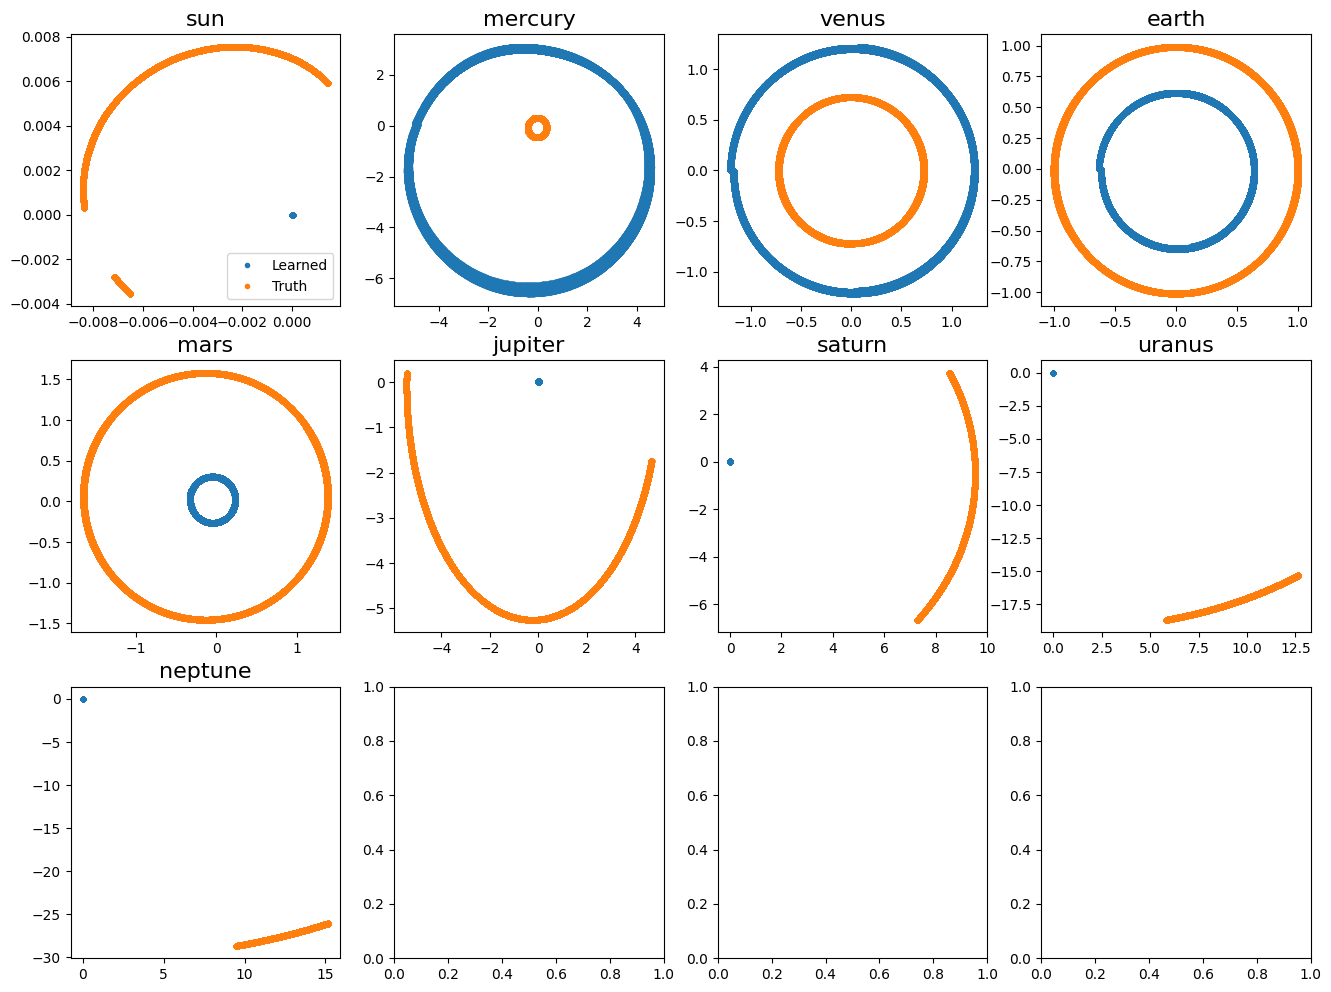

In [31]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    #ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth') #Something is off with this one, use the one below
    ax[i//4, i%4].plot(data_val[:, i, 0], data_val[:, i, 1], '.', label='Truth')

ax[0,0].legend()
#plt.savefig('/Users/Pablo/Desktop/full_learnedmasses.png')

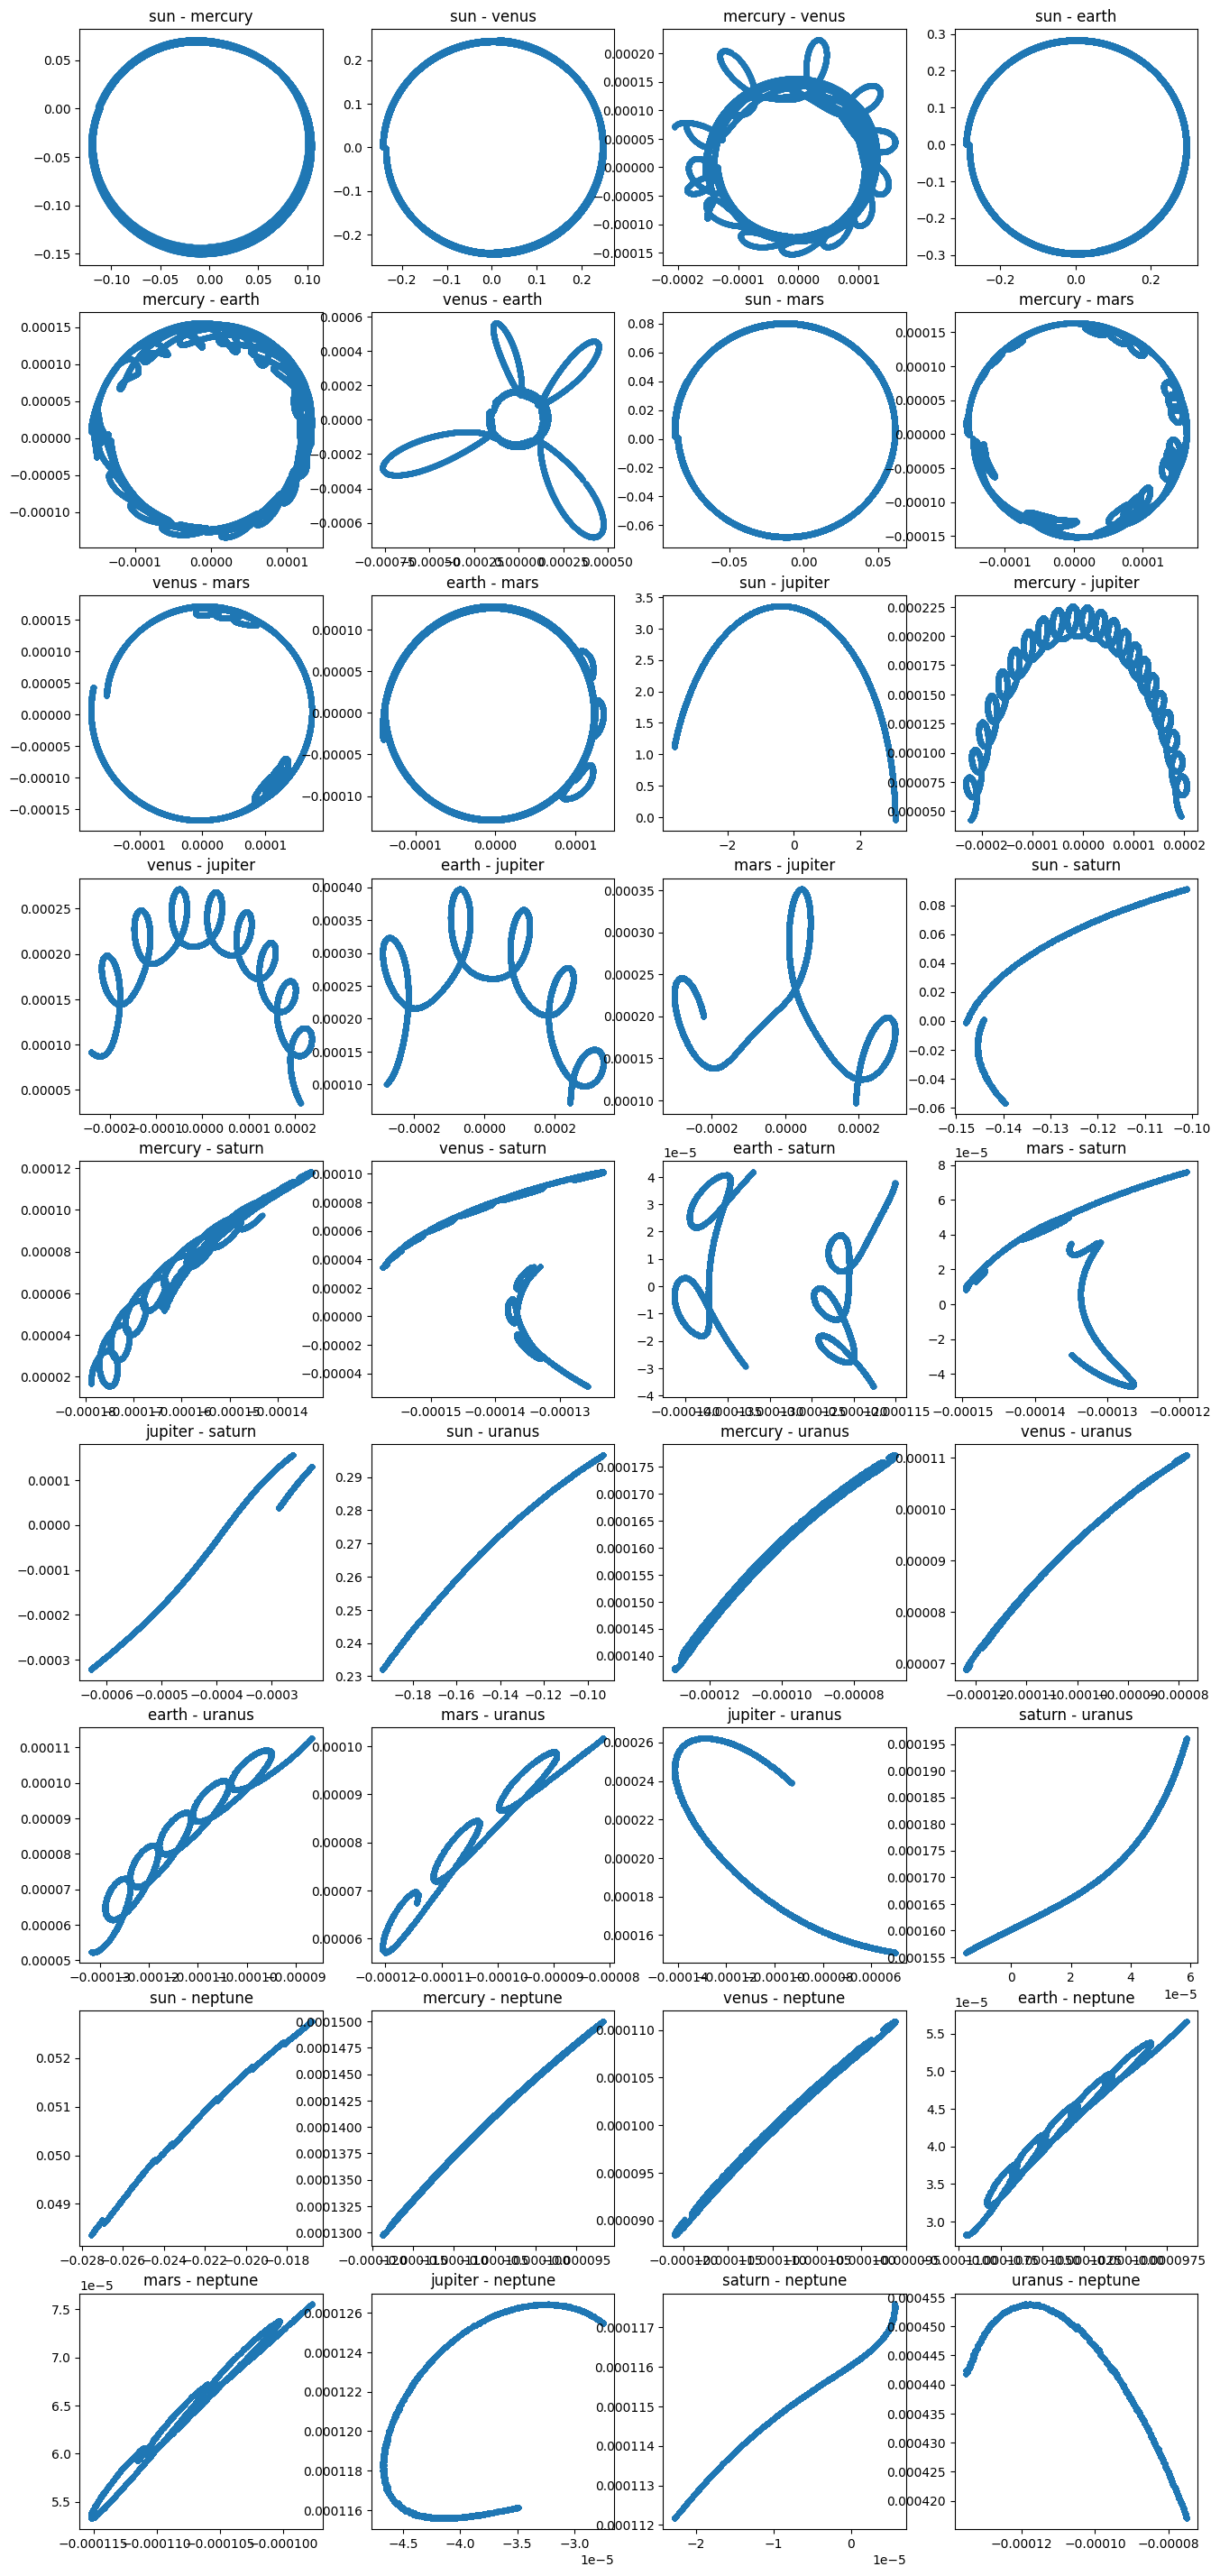

In [32]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    #ax[i//4, i%4].plot(F_val_new[:,i,0], F_val_new[:,i,1], '.')
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

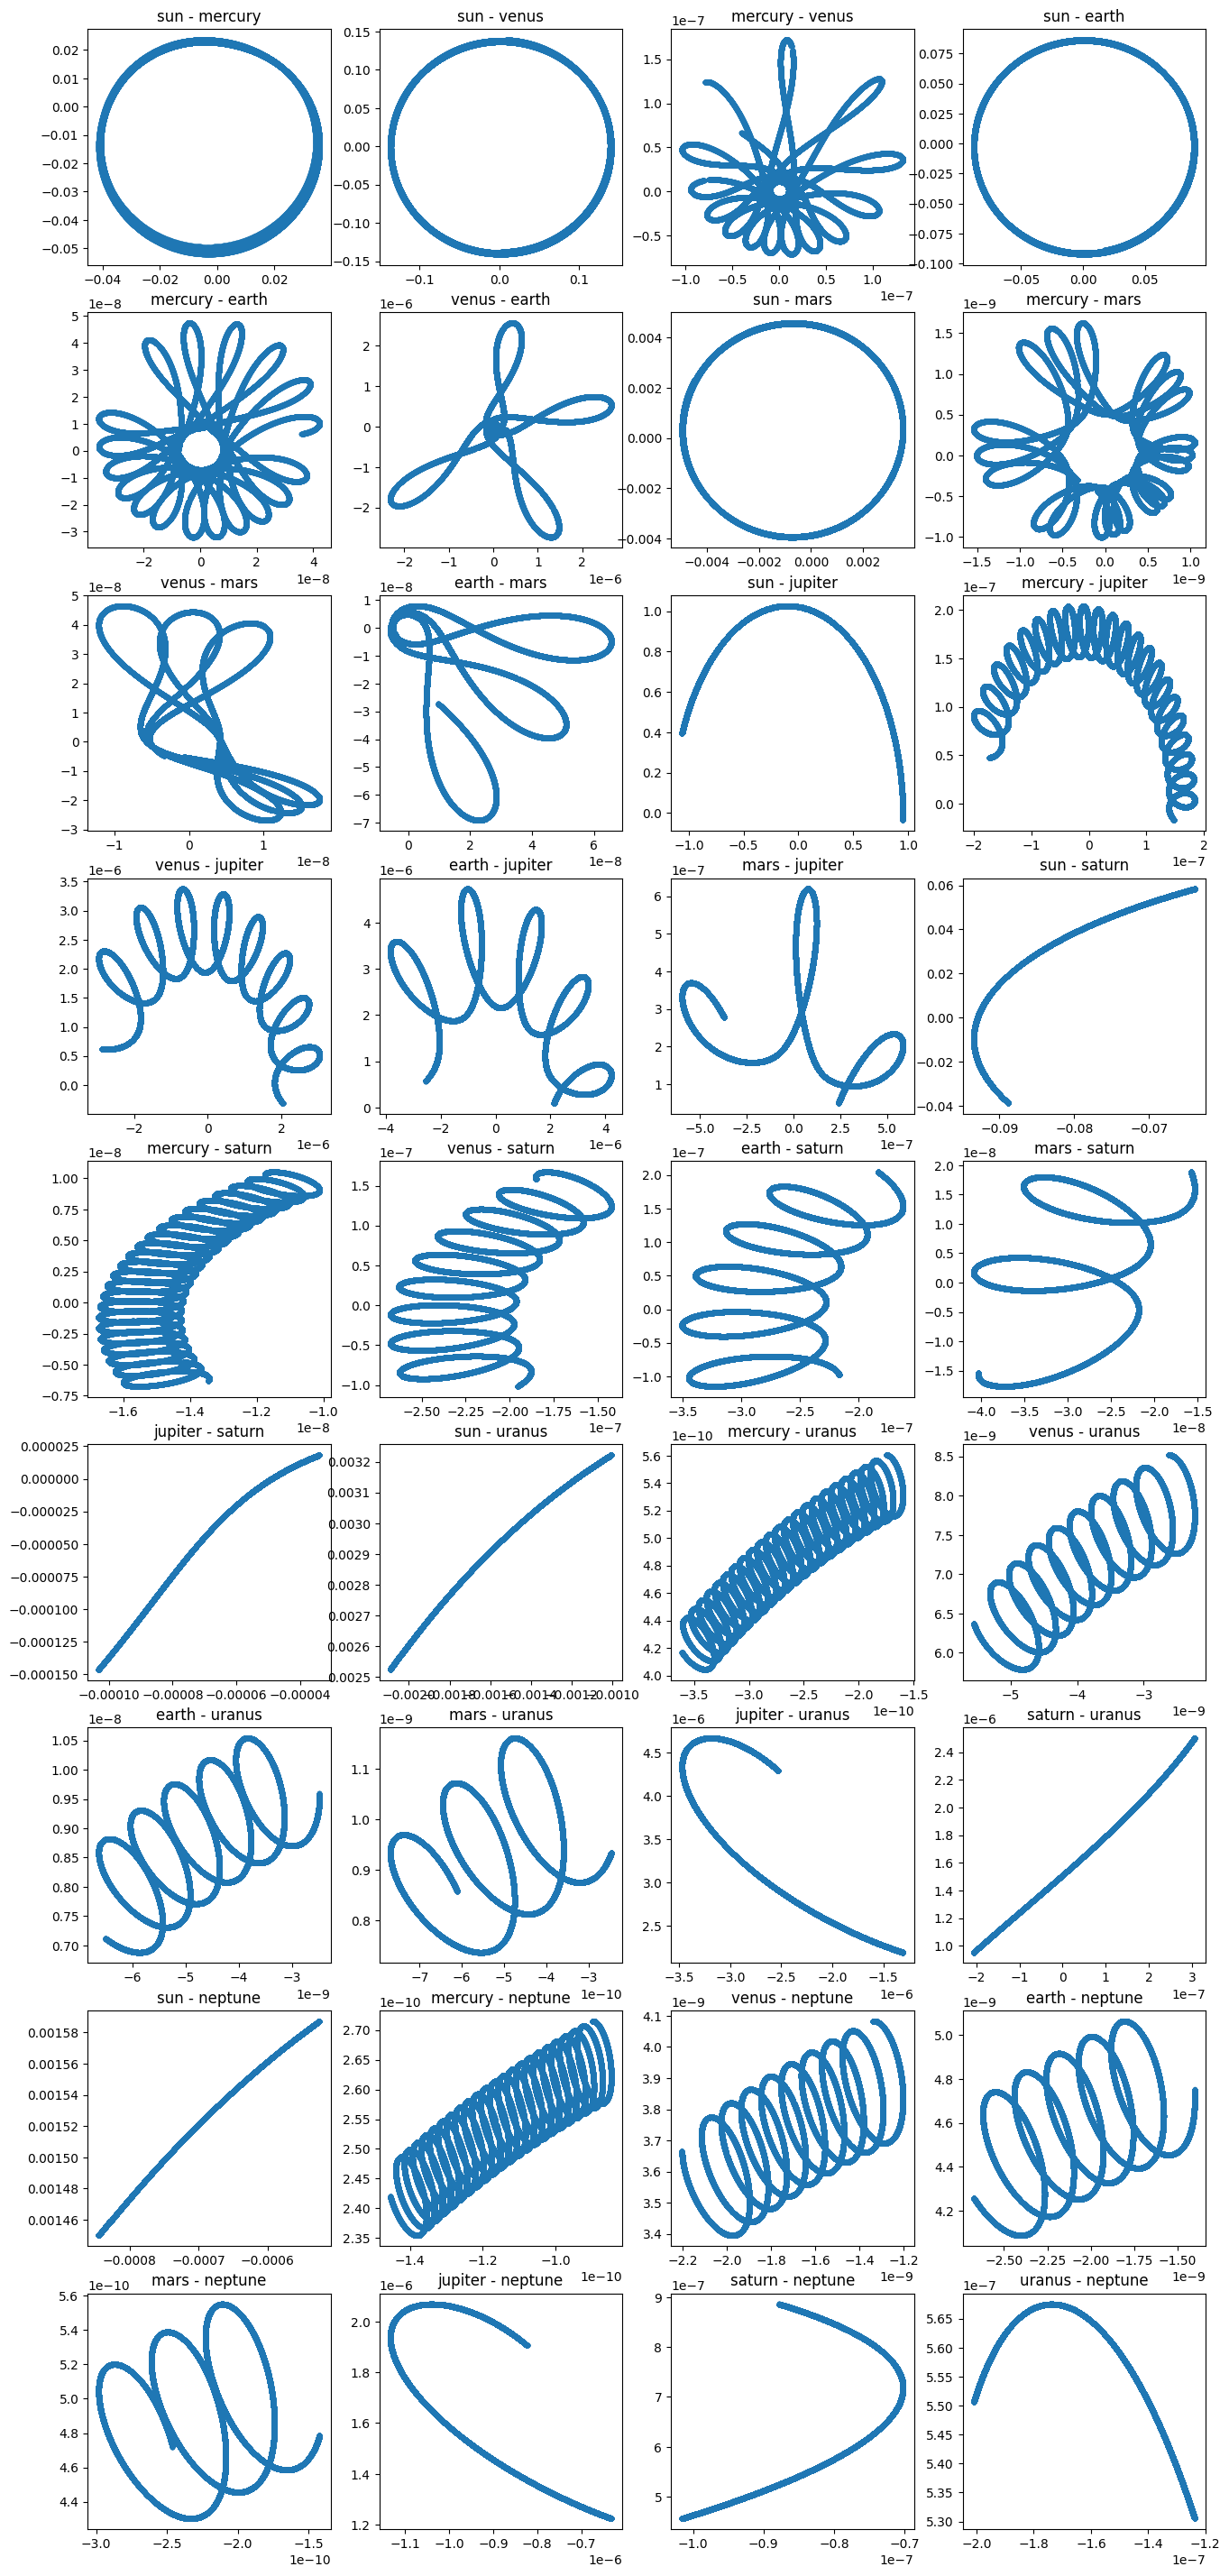

In [35]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    ax[i//4, i%4].plot(F_val[:,i,0]*1e8, F_val[:,i,1]*1e8, '.') # What does calcuting the force between edges and plotting mean?
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    #ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

In [ ]:
plot_time = time.time()

In [ ]:
# ignora el resto , es relacionado al PySymbolicSearch - fuera del scope del proyecto

In [ ]:
X = np.zeros([nval, nedges,9])
X[:,:,2:5] = D_val_np
X[:,:,5] = np.linalg.norm(D_val_np, axis = -1)
X[:,:,6:] = fp
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            X[:,k,0] = 10**(learned_masses[i])
            X[:,k,1] = 10**(learned_masses[j])
            #print(fp[0,k,0], X[0,k,0]*X[0,k,1]*X[0,k,2]/X[0,k,5]**3.)
            k+=1 
            
N = 500
ii = np.random.choice(nval, N, replace = False)
X = X[ii]

X[:,:,2:5], X[:,:,6:] = rotate_data(X[:,:,2:5], X[:,:,6:], uniform = False)

X = np.reshape(X, [N*nedges,9])

In [ ]:
for i in range(len(X)):
    r = np.random.rand()
    if r > 0.5:
        X[i,0], X[i,1]  = X[i,1], X[i,0]

In [ ]:
from sklearn.neighbors import KernelDensity
norm_F = np.linalg.norm(X[:,6:], axis = -1)
X_density = norm_F[:, None]
bin_width = np.max(X_density)/30
kde = KernelDensity(bandwidth=bin_width,
                    kernel='cosine') #Want finite cutoff so not too expensive!
kde.fit(X_density)

KernelDensity(bandwidth=0.00010013720645288762, kernel='cosine')

In [ ]:
grid = np.linspace(0.0, 1.5e-3, num=1000)
density_grid = np.exp(kde.score_samples(grid[:, None]))
grid_idx = np.argmax((X_density < grid[1:]) & (X_density > grid[:-1]), axis=1)
density_values = density_grid[grid_idx]
inv_density = 1 / density_values
inv_density /= inv_density.sum()
np.random.seed(1)
idx_for_pysr = np.random.choice(np.arange(len(X)), size=(1000,), p=inv_density)
X_pysr = X[idx_for_pysr]

In [ ]:
y = X_pysr[:,6] #F_x
#X[:, [0, 1]] = np.exp(X[:, [0, 1]])/1e23 #re-scale to prevent precision issues, since pysr uses 32-bit floats
y /= np.std(y)                                 #same as above

m_std = np.std(X_pysr[:,:2])
x_std = np.std(X_pysr[:,2:5])
X_pysr[:,:2]/= m_std
X_pysr[:,2:]/= x_std

kwargs = dict(populations=64, binary_operators="+ * - /".split(" "),
          unary_operators=[], temp_equation_file=True,
          progress=False, procs=4, annealing=False, maxsize=40, useFrequency=True,  
          variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
          optimizer_algorithm="BFGS",
          optimizer_iterations=10,
          optimize_probability=1.0,)
equations=pysr(X_pysr[:,:6], y, **kwargs)

Running on julia -O3 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmppgebs7f7/runfile.jl
Activating environment on workers.
      From worker 3:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 5:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 4:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
      From worker 2:	 Activating environment at `~/Projets/orbits_tf2/conda-env/lib/python3.7/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.130e+01
Progress: 1 / 6400 total iterations (0.016%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-


Cycles per second: 5.490e+03
Progress: 45 / 6400 total iterations (0.703%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-02  6.336e-04  (0.0008700832 * x)
5           1.776e-02  4.887e-02  ((x * m0) * 0.08632434)
9           1.186e-02  1.009e-01  ((0.11255389 * ((x * m0) / r)) / 0.95853895)
15          1.740e-05  1.087e+00  ((((814.3272 * m0) * m1) * x) * (((0.37332988 / r) / r) / r))


Cycles per second: 5.410e+03
Progress: 46 / 6400 total iterations (0.719%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.961e-02  -0.000e+00  0.0020922422
3           1.958e-02  6.336e-04  (0.0008700832 * x)
5           1.776e-02  4.887e-02  ((x * m0) * 0.08632434)
9           1.186e-02  1.009e-01  ((0.11255389 * ((x * m0) / r)) / 0.95853895)
15          1.740e-05  1.087e+00  ((((814.3272 * m0) * m1) * x) * (((0.37332988

In [ ]:
from pysr import best
best(equations)

304.012675856736*m0*m1*x/r**3

In [ ]:
sr_time = time.time()

In [ ]:
print('Total time: ', str(datetime.timedelta(seconds=sr_time - start_time)))
print('---------------')
print('Time to set up data: ', str(datetime.timedelta(seconds=setup_time - start_time)))
print('Time for training: ', str(datetime.timedelta(seconds=train_time - setup_time)))
print('Time for plotting: ', str(datetime.timedelta(seconds=plot_time - train_time)))
print('Time for symbolic regression: ', str(datetime.timedelta(seconds=sr_time - plot_time)))

Total time:  4:36:25.192605
---------------
Time to set up data:  0:03:55.302859
Time for training:  3:18:34.579545
Time for plotting:  0:02:32.826115
Time for symbolic regression:  1:11:22.484086


# TO DO:

### To finish the project
- Working!

### To clean the model
- Improve plotting

# Requirements
- The graphnets tensorflow 2 installation
- pysr
- matplotlib

# Debugging (ignore)

In [ ]:
from tensorflow.python.keras.utils import tf_utils

In [ ]:
loss_tr = 1

i = 0
while not np.isnan(loss_tr):
    model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)
    model.compile(run_eagerly=True)

    model.fit(train_ds, 
              verbose = 2,
              epochs = 1,
              steps_per_epoch = 10,
              callbacks=[
                    tf.keras.callbacks.TerminateOnNaN()]
              #validation_data=test_ds
             )
    
    loss_tr = tf_utils.to_numpy_or_python_type(model.evaluate(ini_ds, verbose = 0))
    i+=1
    if i>1000: 
        print('SUCCESS!')
        break
    #print(loss_tr)




In [ ]:
loss_tr = np.NaN

while np.isnan(loss_tr):
    model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)
    model.compile(run_eagerly=True)

    model.fit(train_ds, 
              verbose = 2,
              epochs = 1,
              steps_per_epoch = 10,
              callbacks=[
                    tf.keras.callbacks.TerminateOnNaN()]
              #validation_data=test_ds
             )
    
    loss_tr = tf_utils.to_numpy_or_python_type(model.evaluate(ini_ds, verbose = 0))
    #print(loss_tr)

